# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 27.91 MiB/s, done.
Resolving deltas: 100% (3/3), done.


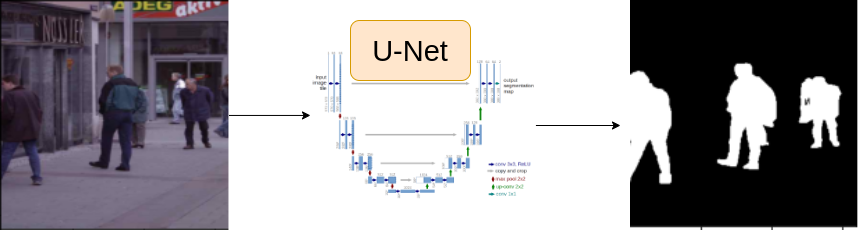

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE= '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR= '/content/'

DEVICE= 'cuda'

EPOCHS =25
LR= 0.003
IMG_SIZE= 320
BATCH_SIZE= 16

ENCODER= 'timm-efficientnet-b0'
WEIGHTS= 'imagenet'


In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row= df.iloc[4]
image_path= row.images
mask_path= row.masks

image= cv2.imread(DATA_DIR+image_path)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask= cv2.imread(DATA_DIR+mask_path, cv2.IMREAD_GRAYSCALE) /255.0

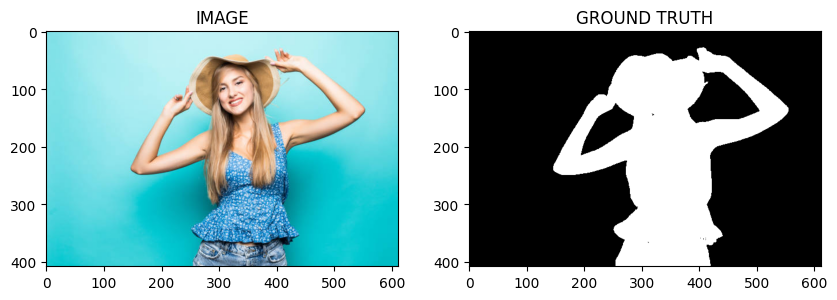

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], additional_targets={'mask': 'mask'})

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ], additional_targets={'mask': 'mask'})

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")
        mask = np.expand_dims(mask, axis=-1)

        # Resize image and mask to the same dimensions before augmentations
        resize = A.Resize(IMG_SIZE, IMG_SIZE)
        resized = resize(image=image, mask=mask)
        image = resized['image']
        mask = resized['mask']

        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # (h, w, c) --> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.from_numpy(image) / 255.0
        mask = torch.round(torch.from_numpy(mask) / 255.0)

        return image, mask


In [14]:
trainset= SegmentationDataset(train_df, get_train_augs())
validset= SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


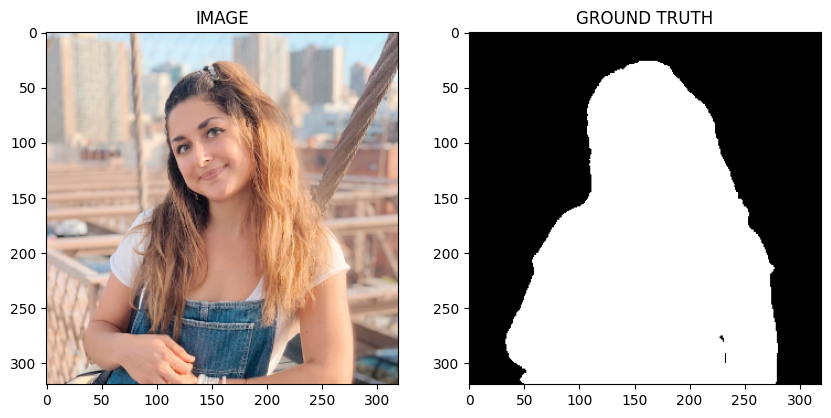

In [16]:
idx= 23
image, mask= trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader


In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
print (f'total no. of batches in train loader : {len(trainloader)}')
print (f'total no. of batches in valid loader : {len(validloader)}')

total no. of batches in train loader : 15
total no. of batches in valid loader : 4


In [20]:
for image, mask in trainloader:
  break

print(f'image shape : {image.shape}')
print(f'mask shape : {mask.shape}')

image shape : torch.Size([16, 3, 320, 320])
mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [33]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels=3, # channels of images
        classes=1, # binary segmentation problem
        activation= None
    )
  def forward(self, images,masks=None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2= nn.BCEWithLogitsLoss()(logits,masks)
      loss = loss1 + loss2
      return logits, loss
    return logits

In [34]:
model= SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [35]:
def train_fn(data_loader, model, optimizer):
  loop = tqdm(data_loader, leave=True)
  model.train()
  total_loss= 0.0
  for images, masks in loop:
    images= images.to(DEVICE)
    masks= masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss= model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    loop.set_postfix(loss=total_loss/len(data_loader))
  return total_loss/len(data_loader)

In [39]:
def eval_fn(data_loader, model):
  loop = tqdm(data_loader, leave=True)
  model.eval()
  total_loss= 0.0
  with torch.no_grad():
    for images, masks in loop:
      images= images.to(DEVICE)
      masks= masks.to(DEVICE)
      logits, loss= model(images,masks)
      total_loss += loss.item()
      loop.set_postfix(loss=total_loss/len(data_loader))
    return total_loss/len(data_loader)

# Task 8 : Train Model

In [37]:
optimizer= torch.optim.Adam(model.parameters(), lr=LR)

In [40]:
best_valid_loss=np.Inf

for i in range (EPOCHS):

  train_loss= train_fn(trainloader, model, optimizer)
  valid_loss= eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Model Saved')
    best_valid_loss= valid_loss

  print(f'Best Validation Loss : {best_valid_loss}')


100%|██████████| 4/4 [00:00<00:00,  4.77it/s, loss=0.274]


Model Saved
Best Validation Loss : 0.2738039940595627


100%|██████████| 4/4 [00:01<00:00,  3.67it/s, loss=0.353]


Best Validation Loss : 0.2738039940595627


100%|██████████| 4/4 [00:00<00:00,  5.08it/s, loss=0.263]


Model Saved
Best Validation Loss : 0.2630815617740154


100%|██████████| 4/4 [00:00<00:00,  4.57it/s, loss=0.27]


Best Validation Loss : 0.2630815617740154


100%|██████████| 4/4 [00:00<00:00,  4.84it/s, loss=0.345]


Best Validation Loss : 0.2630815617740154


100%|██████████| 4/4 [00:00<00:00,  4.93it/s, loss=0.285]


Best Validation Loss : 0.2630815617740154


100%|██████████| 4/4 [00:00<00:00,  4.63it/s, loss=0.247]


Model Saved
Best Validation Loss : 0.24667201563715935


100%|██████████| 4/4 [00:00<00:00,  4.99it/s, loss=0.207]


Model Saved
Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:00<00:00,  4.13it/s, loss=0.23]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:00<00:00,  4.73it/s, loss=0.217]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:00<00:00,  4.88it/s, loss=0.229]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.64it/s, loss=0.256]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.79it/s, loss=0.278]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.73it/s, loss=0.271]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.55it/s, loss=0.264]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:00<00:00,  4.89it/s, loss=0.275]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.86it/s, loss=0.27]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:00<00:00,  4.91it/s, loss=0.23]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:00<00:00,  4.86it/s, loss=0.306]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.48it/s, loss=0.243]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.85it/s, loss=0.231]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:00<00:00,  4.91it/s, loss=0.23]


Best Validation Loss : 0.20739518105983734


100%|██████████| 4/4 [00:01<00:00,  3.62it/s, loss=0.194]


Model Saved
Best Validation Loss : 0.19381612166762352


100%|██████████| 4/4 [00:01<00:00,  2.67it/s, loss=0.226]


Best Validation Loss : 0.19381612166762352


100%|██████████| 4/4 [00:01<00:00,  3.74it/s, loss=0.193]

Model Saved
Best Validation Loss : 0.19348052889108658


# Task 9 : Inference

In [47]:
idx = 56
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
logits_mask= model(image.to(DEVICE).unsqueeze(0)) # (C, H, W)--> (1, C, H, W)
pred_mask= (torch.sigmoid(logits_mask) > 0.5)*1.0




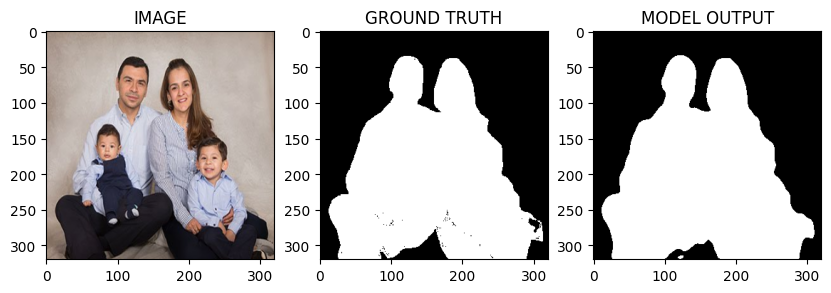

In [48]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya